In [14]:
import torch
from torch import nn
import torchvision
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
from torchvision import datasets
data_folder = "~/cifar10/cifar/"
datasets.CIFAR10(data_folder, download=True)

100%|██████████████████████████████████████████████████████| 170M/170M [00:21<00:00, 7.89MB/s]


Extracting /home/zanchet/cifar10/cifar/cifar-10-python.tar.gz to /home/zanchet/cifar10/cifar/


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/zanchet/cifar10/cifar/
    Split: Train

In [7]:
class Colorize(torchvision.datasets.CIFAR10):
    def __init__(self, root, train):
        super().__init__(root, train)

    def __getitem__(self, ix):
        im, _ = super().__getitem__(ix)
        bw = im.convert('L').convert('RGB')
        bw = np.array(bw)/255.
        im = np.array(im)/255.
        bw, im = [torch.tensor(i).permute(2,0,1).to(device).float() for i in [bw, im]]
        return bw, im

In [8]:
trn_ds = Colorize(data_folder, train=True)

In [9]:
val_ds = Colorize(data_folder, train=False)

In [12]:
trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size = 256, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = 256, shuffle=False)

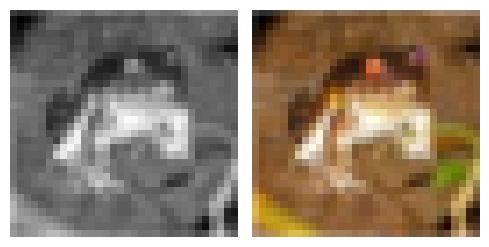

In [13]:
a,b = trn_ds[0]
subplots([a,b], nc=2)

In [18]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

class DownConv(nn.Module):
    def __init__(self, ni, no, maxpool = True):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2) if maxpool else Identity(),
            nn.Conv2d(ni, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no,no,2,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
    def forward(self, x):
        return self.model(x)

class UpConv(nn.Module):
    def __init__(self, ni, no, maxpool = True):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(ni, no, 2, stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(no+no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no,no,3,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
    def forward(self, x, y):
        x = self.convtranspose(x)
        x = torch.cat([x,y], axis=1)
        x = self.convlayers(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        self.d1 = DownConv(3, 64, maxpool=False)
        self.d2 = DownConv(64, 128)
        self.d3 = DownConv(128, 256)
        self.d4 = DownConv(256, 512)
        self.d5 = DownConv(512, 1024)
        self.u5 = UpConv(1024, 512)
        self.u4 = UpConv(512, 256)
        self.u3 = UpConv(256, 128)
        self.u2 = UpConv(128, 64)
        self.u1 = nn.Conv2d(64, 3, kernel_size=1, stride=1)

    def forward(self, x):
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        x4 = self.d5(x3)
        X4 = self.u5(x4, x3)
        X3 = self.u4(X4, x2)
        X2 = self.u3(X3, x1)
        X1 = self.u2(X2, x0)
        return self.u1(X1)

In [ ]:
def get_model():
    model = UNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

In [19]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    x, y = data
    _y = model(x)
    optimizer.zero_grad()
    loss = criterion(_y, y)
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
@torch.no_grad()
def validate_batch(model, data, criterion):
    